In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import psycopg2
from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [51]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.



     ---------------------------------------- 20.2/20.2 MB 7.1 MB/s eta 0:00:00


# Read data for the location of Berlin and visualize the time series

In [40]:
df1 = pd.read_csv('challenge-data/truth/2021-05-16_LK_cases.csv',index_col='target', parse_dates=True)
df_train = pd.read_parquet(r'challenge-data/truth/2022-09-04_LK_cases.parquet')

df_test = pd.read_csv('challenge-data/evaluation/2022-10-02_LK_cases.csv',index_col='target', parse_dates=True)
df_train = df_train.set_index('target')
#df_train = df_train.groupby('location')
#df_test = df_test.set_index('target')
df_test=df_test.tail(28)
df_train.head(), df_test.head()

(            location  value
 target                     
 2020-02-01    1001.0    0.0
 2020-02-02    1001.0    0.0
 2020-02-03    1001.0    0.0
 2020-02-04    1001.0    0.0
 2020-02-05    1001.0    0.0,
             location       value
 target                          
 2022-09-03     16077  212.775590
 2022-09-04     16077  201.457739
 2022-09-05     16077  199.194169
 2022-09-06     16077  182.217393
 2022-09-07     16077  196.930599)

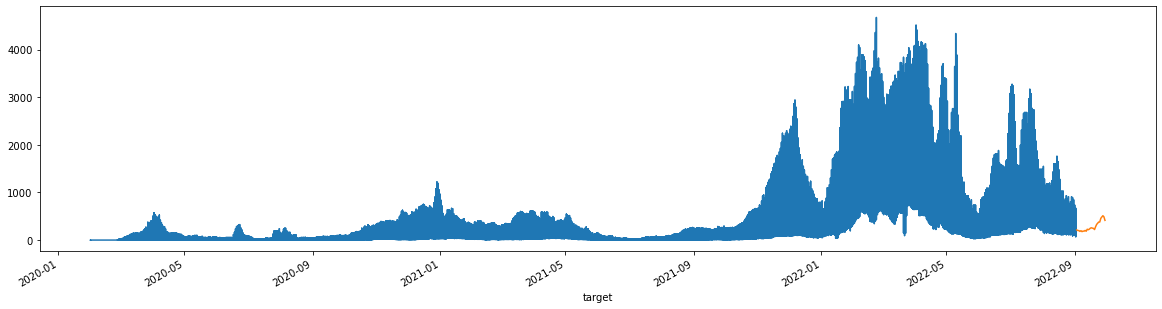

In [14]:
df_train.value.plot(figsize=(20,5))
df_test.value.plot()
df_test, df_train = df_test.drop('location', axis=1), df_train.drop('location', axis=1)

# **Split in train and test data**  

470
            value
target           
2020-02-01    0.0
2020-02-02    0.0
2020-02-03    0.0
2020-02-04    0.0
2020-02-05    0.0
                 value
target                
2021-03-17  114.261001
2021-03-18  123.070844
2021-03-19  122.002985
2021-03-20  126.274424
2021-03-21  132.414618
410 60


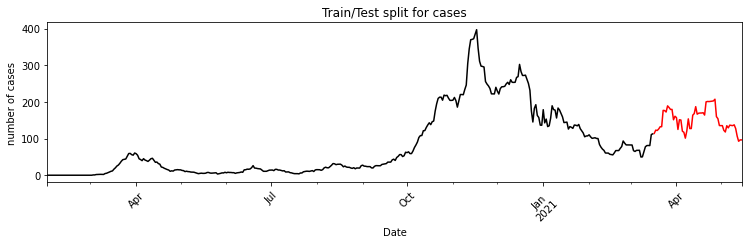

In [5]:
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#df.target=pd.to_datetime(df['target'])
print(len(df1))
#print(df1.tail())

# train = df[df.target<datetime(2021, 4, 17)]
# test = df[df.target>datetime(2021, 4, 17)]

train = df1.iloc[:410]
test = df1.iloc[410:]
print(train.head())
print(test.head())
print(len(train), len(test))
train.value.plot(color='black')
test.value.plot(color='red')
plt.ylabel('number of cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for cases")
plt.show()



# **1. Perform ARIMA regression for this time series data**

In [29]:
result = auto_arima(combined_df.value, m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3017.010, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3022.740, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3001.393, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3003.605, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3021.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3005.631, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2992.584, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2993.853, Time=0.41 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2998.704, Time=0.22 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3011.361, Time=0.19 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=2993.448, Time=0.31 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2993.792, Time=0.49 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2992.001, Time=0.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3001.826, Time=0.15 sec
 ARIMA(0,1,1)(2,0,1

In [30]:
model = SARIMAX(combined_df['value'], order=(3,1,5))
result = model.fit()

C:\Users\nishant.nigam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nishant.nigam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [31]:
forecast=model.predict(n_periods=60, return_conf_int=True)

TypeError: predict() missing 1 required positional argument: 'params'

TypeError: index type not supported

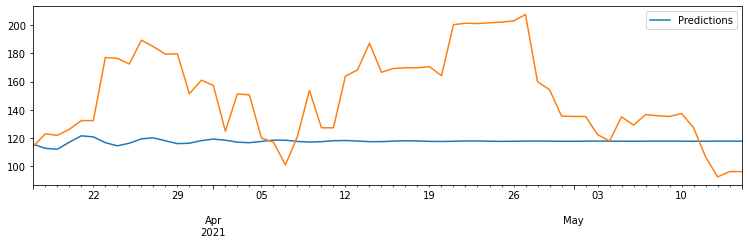

In [42]:
start = len(train)
end = len(train)+len(test)-1

pred = result.predict(start=start, end=end, typ='levels', dynamic=False).rename('Predictions')

#test.value.plot()
pred.plot(legend=True)
combined_df_test.value.plot(legend=True)
plt.show()

print(len(pred))
print(len(combined_df_test.values))

# **2. Perform Linear Regression for the time series**

r =  0.6433958984441368 
 p =  2.831946327349688e-56 
 s =  0.02314029227776391


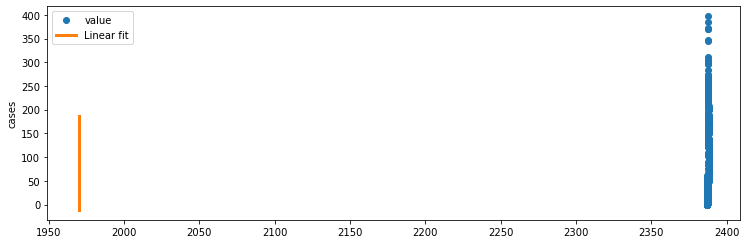

In [28]:
import scipy.stats as sp

df2 = pd.read_csv('challenge-data/truth/2021-05-16_LK_cases.csv')

y=np.array(df2[df2.location==11001]['value'].dropna().values, dtype=float)
x=np.array(df2[df2.location==11001]['target'].dropna().index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)
f, ax = plt.subplots(1, 1)
df2[df2.location==11001]['value'].dropna().plot(ax=ax,marker='o', ls='')
ax.plot(xf1, yf,label='Linear fit', lw=3)

plt.ylabel('cases')
ax.legend();

# **3. RNN Implementation for the time series data**

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()


**Scale the values between 0 and 1**

In [17]:
#df_train = df_train.drop('location')
scaler.fit(df_train)
scaled_train=scaler.transform(df_train)
scaled_test=scaler.transform(df_test)
scaled_train[-10:]

array([[0.05374085],
       [0.04502612],
       [0.04938348],
       [0.04793103],
       [0.04962556],
       [0.04865726],
       [0.04889933],
       [0.04672065],
       [0.05010971],
       [0.03897422]])

**Prepare the RNN model**

In [25]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_input = 60
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=64)
#generator = TimeseriesGenerator(df_train, df_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#model.summary()
generator[0]

(array([[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00214046],
         [0.00237828],
         [0.00261611]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00237828],
         [0.00261611],
         [0.00261611]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.00261611],
         [0.00261611],
         [0.0016648 ]],
 
        ...,
 
        [[0.0016648 ],
         [0.00190263],
         [0.0016648 ],
         ...,
         [0.00047566],
         [0.00071349],
         [0.00071349]],
 
        [[0.00190263],
         [0.0016648 ],
         [0.00142697],
         ...,
         [0.00071349],
         [0.00071349],
         [0.00071349]],
 
        [[0.0016648 ],
         [0.00142697],
         [0.00142697],
         ...,
         [0.00071349],
         [0.00071349],
         [0.00047566]]]),
 array([[0.00261611],
        [0.0016648 ],
        [0.

**Fit the RNN model on the training data**

In [26]:
model.fit(generator, epochs=20)

Epoch 1/20
6068/6068 [==============================] - 93s 15ms/step - loss: 2.4208e-04
Epoch 2/20
6068/6068 [==============================] - 96s 16ms/step - loss: 7.5543e-05
Epoch 3/20
6068/6068 [==============================] - 96s 16ms/step - loss: 7.0748e-05
Epoch 4/20
6068/6068 [==============================] - 96s 16ms/step - loss: 6.9258e-05
Epoch 5/20
6068/6068 [==============================] - 96s 16ms/step - loss: 6.7227e-05
Epoch 6/20
6068/6068 [==============================] - 96s 16ms/step - loss: 6.5504e-05
Epoch 7/20
6068/6068 [==============================] - 96s 16ms/step - loss: 6.5108e-05
Epoch 8/20
6068/6068 [==============================] - 97s 16ms/step - loss: 6.4121e-05
Epoch 9/20
6068/6068 [==============================] - 99s 16ms/step - loss: 6.3200e-05
Epoch 10/20
6068/6068 [==============================] - 99s 16ms/step - loss: 6.3525e-05
Epoch 11/20
6068/6068 [==============================] - 96s 16ms/step - loss: 6.2728e-05
Epoch 12/20
6068/60

**Plot loss per epoch from the training phase**

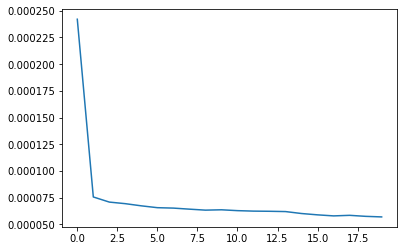

In [27]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Perform prediction for the test data**

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch.shape)

for i in range(len(df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

(1, 60, 1)
1/1 [==============================] - 0s 14ms/step
[0.03594264]
1/1 [==============================] - 0s 0s/step
[0.03448609]
1/1 [==============================] - 0s 14ms/step
[0.03256091]
1/1 [==============================] - 0s 14ms/step
[0.03158201]
1/1 [==============================] - 0s 16ms/step
[0.03047541]
1/1 [==============================] - 0s 13ms/step
[0.03033389]
1/1 [==============================] - 0s 0s/step
[0.03140952]
1/1 [==============================] - 0s 14ms/step
[0.03161442]
1/1 [==============================] - 0s 12ms/step
[0.0308679]
1/1 [==============================] - 0s 17ms/step
[0.03040919]
1/1 [==============================] - 0s 14ms/step
[0.03027203]
1/1 [==============================] - 0s 15ms/step
[0.03008315]
1/1 [==============================] - 0s 13ms/step
[0.02995363]
1/1 [==============================] - 0s 14ms/step
[0.02996513]
1/1 [==============================] - 0s 19ms/step
[0.02988249]
1/1 [==============

**Rescale the predicted values to get the actual true predictions and plot them with the test data**

28

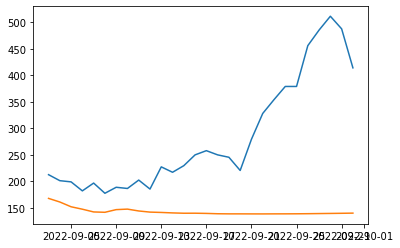

In [49]:
true_predictions = scaler.inverse_transform(test_predictions)
df_test['Predictions'] = true_predictions
#df_test.drop('location', axis=1)
plt.plot(df_test.target,df_test.value)
plt.plot(df_test.target,df_test.Predictions)
#df_test.reset_index(inplace=True)
len(df_test)

**Calculate the root mean squared error**

In [50]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(df_test['value'],df_test['Predictions']))
print(rmse)

176.25140304906049


In [80]:
df_test=df_test.drop(['sample_id'], axis=1)

In [54]:
df_test['location'] = 16077

In [126]:
temp_df = df_test.copy()
#df_test = df_test.append(temp_df)
#new.sample_id=0
dfs = []
for i in range(100):
    new = temp_df.copy()
    new.sample_id = i
    dfs.append(new)
    #df_test['sample_id'] = i
    
  
res = pd.concat(dfs, ignore_index=True)
res= res[['location', 'target', 'sample_id', 'value']]
len(res), res.head(), res.tail()

(2800,
    location     target  sample_id       value
 0     16077 2022-09-03          0  168.043753
 1     16077 2022-09-04          0  161.233910
 2     16077 2022-09-05          0  152.233066
 3     16077 2022-09-06          0  147.656340
 4     16077 2022-09-07          0  142.482621,
       location     target  sample_id       value
 2795     16077 2022-09-26         99  139.177177
 2796     16077 2022-09-27         99  139.423758
 2797     16077 2022-09-28         99  139.668240
 2798     16077 2022-09-29         99  139.940275
 2799     16077 2022-09-30         99  140.246109)

In [127]:
res.to_parquet('2022-09-04_model_LK_cases.parquet')

In [129]:
df_par = pd.read_parquet('2022-09-04_model_LK_cases.parquet')
df_par.head()

,location,target,sample_id,value
0,16077,2022-09-03,0,168.043753
1,16077,2022-09-04,0,161.233910
2,16077,2022-09-05,0,152.233066
3,16077,2022-09-06,0,147.656340
4,16077,2022-09-07,0,142.482621


# Get Data from covid_results_v5 and covid_network_v5_topology tables from database

In [88]:
db_usr, db_pwd = 'nishant_niram', 'jsadrelk3Fsh3Dsw'
conn = psycopg2.connect('host=ex03.ionos.netcheck.de port=5432 dbname=x4intern_covid user='+db_usr+' password='+db_pwd)
cur = conn.cursor()

**Get training data**

In [7]:
query = """
    select * from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2020-02-01' and '2021-03-16'; 
"""
cur.execute(query)
df2 = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(df2.columns), len(df2))
df2.tail(5)

27 410


,day,location,submitted_on,ktot_1,k2tot_1,ndid_1,npop_1,pdid_1,pping_1,plink_1,...,k2tot_12,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums
405,2021-03-12,Berlin,2022-08-11,1166,1600,13340,3292017,0.004052,0.006848,0.026470,...,0,0.947853,16.134666,1.049749,1108.90320,257.942930,68.727980,20.458439,68.727980,0.0
406,2021-03-13,Berlin,2022-08-11,1006,1296,12668,3292017,0.003848,0.006361,0.024910,...,0,0.991139,16.403582,1.114508,977.08386,216.152940,59.565277,17.224222,59.565277,0.0
407,2021-03-14,Berlin,2022-08-11,820,1010,12229,3292017,0.003715,0.006012,0.023776,...,0,1.013555,15.032245,1.110379,781.14200,250.414440,51.964430,20.496918,51.964430,0.0
408,2021-03-15,Berlin,2022-08-11,1159,1447,13309,3292017,0.004043,0.006828,0.026408,...,0,0.943188,16.150587,1.002062,744.61926,128.788570,46.104780,10.834803,46.104780,0.0
409,2021-03-16,Berlin,2022-08-11,1141,1409,13433,3292017,0.004080,0.006763,0.026200,...,0,0.949576,15.731339,0.978852,684.64520,126.973564,43.521100,10.779391,43.521100,0.0


**Get test data**

In [8]:
query = """
    select * from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2021-03-17' and '2021-05-15';
"""
cur.execute(query)
test_df = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(test_df.columns), len(test_df))
test_df.head(5)

27 60


,day,location,submitted_on,ktot_1,k2tot_1,ndid_1,npop_1,pdid_1,pping_1,plink_1,...,k2tot_12,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums
0,2021-03-17,Berlin,2022-08-11,1192,1476,13425,3292017,0.004078,0.006903,0.026645,...,0,0.953021,16.179354,0.984753,702.74945,137.195270,43.434950,11.123307,43.434950,0.0
1,2021-03-18,Berlin,2022-08-11,1093,1335,13420,3292017,0.004077,0.006996,0.026941,...,0,0.953101,14.683521,0.929441,586.41270,102.754486,39.936790,9.525873,39.936790,0.0
2,2021-03-19,Berlin,2022-08-11,1202,1546,13462,3292017,0.004089,0.006968,0.026851,...,0,0.953953,16.101212,0.995845,831.27130,171.063960,51.627872,13.817427,51.627872,0.0
3,2021-03-20,Berlin,2022-08-11,918,1124,12821,3292017,0.003895,0.006438,0.025160,...,0,1.002172,14.468341,1.004917,656.34296,128.756760,45.364080,12.050028,45.364080,0.0
4,2021-03-21,Berlin,2022-08-11,748,850,12255,3292017,0.003723,0.006146,0.024215,...,0,1.012062,13.406625,0.996311,401.82428,84.678420,29.972069,8.543532,29.972069,0.0


In [37]:
query = """
    select * from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2021-03-17' and '2021-05-15';
"""
cur.execute(query)
test_df = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(test_df.columns), len(test_df))
test_df.head(5)

27 60


,day,location,submitted_on,ktot_1,k2tot_1,ndid_1,npop_1,pdid_1,pping_1,plink_1,...,k2tot_12,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums
0,2021-03-17,Berlin,2022-08-11,1192,1476,13425,3292017,0.004078,0.006903,0.026645,...,0,0.953021,16.179354,0.984753,702.74945,137.195270,43.434950,11.123307,43.434950,0.0
1,2021-03-18,Berlin,2022-08-11,1093,1335,13420,3292017,0.004077,0.006996,0.026941,...,0,0.953101,14.683521,0.929441,586.41270,102.754486,39.936790,9.525873,39.936790,0.0
2,2021-03-19,Berlin,2022-08-11,1202,1546,13462,3292017,0.004089,0.006968,0.026851,...,0,0.953953,16.101212,0.995845,831.27130,171.063960,51.627872,13.817427,51.627872,0.0
3,2021-03-20,Berlin,2022-08-11,918,1124,12821,3292017,0.003895,0.006438,0.025160,...,0,1.002172,14.468341,1.004917,656.34296,128.756760,45.364080,12.050028,45.364080,0.0
4,2021-03-21,Berlin,2022-08-11,748,850,12255,3292017,0.003723,0.006146,0.024215,...,0,1.012062,13.406625,0.996311,401.82428,84.678420,29.972069,8.543532,29.972069,0.0


        location      target       value
290983   16077.0  2022-01-04  375.752637
290984   16077.0  2022-01-05  340.667300
290985   16077.0  2022-01-06  303.318394
290986   16077.0  2022-01-07  316.899814
290987   16077.0  2022-01-08  322.558740
target
2020-02-01         6.520770
2020-02-02         6.520770
2020-02-03         6.587965
2020-02-04         7.995626
2020-02-05         6.578827
                  ...      
2022-01-04    112765.223057
2022-01-05    121666.853585
2022-01-06    126345.060327
2022-01-07    133698.305399
2022-01-08    139095.625905
Name: value, Length: 708, dtype: float64


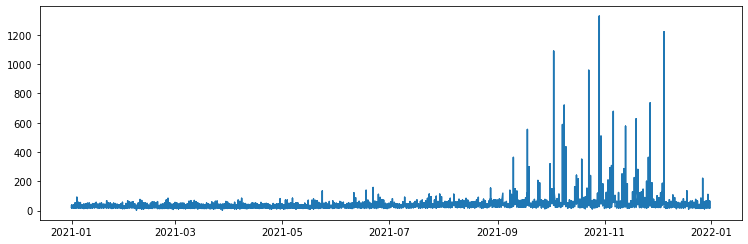

<AxesSubplot:xlabel='target'>

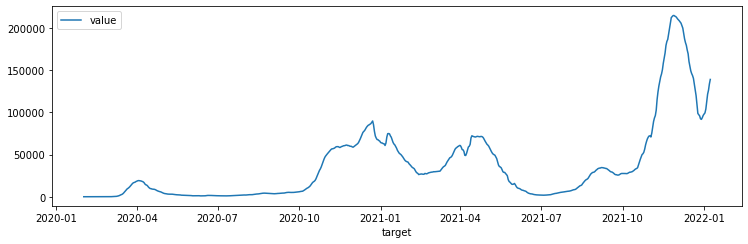

In [108]:
total_cases_df = pd.read_parquet(r'challenge-data/truth/2022-01-09_LK_cases.parquet' )

print(total_cases_df.tail())
vaccination_df = pd.read_excel('Impfquotenmonitoring.xlsx', 'Impfungen_proTag')

query = """
    select day,cx from covid_results_v5 crv  
    where crv.day between '2021-01-01' and '2021-12-31'; 
"""
cur.execute(query)
cx_df = pd.DataFrame(cur.fetchall(), columns = ['day','cx'])

total_cases_df = total_cases_df.groupby(['target']).value.sum()
print(total_cases_df)
#print(total_cases_df.groupby('target').sum().tail())
# vaccination_df_sliced = vaccination_df.loc[:635] #till 2022-09-23
# vaccination_df_sliced['Erste Impfung'].plot(legend=True)
plt.plot(cx_df.day,cx_df.cx)
plt.show()
total_cases_df.plot(legend=True)
#total_cases_df.plot(legend=True)

In [97]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


**Drop unwanted columns**

In [39]:
#df2 = df2.drop(['location', 'submitted_on', 'npop_1', 'npop_2', 'ndid_2'], axis=1)
test_df = test_df.drop(['location', 'submitted_on', 'npop_1', 'npop_2', 'ndid_2'], axis=1)
print(len(test_df.columns))

22


**Join the given time series to covid_results_v5 data with index as 'day'**

In [40]:
#df2=df2.set_index('day')
#combined_df = pd.concat([df2, train.value.to_frame()], axis=1)
#combined_df.columns
test_df=test_df.set_index('day')
combined_df_test = pd.concat([test_df, test.value.to_frame()], axis=1)

print(len(combined_df_test.columns), len(combined_df.columns))

22 22


C:\Users\nishant.nigam\AppData\Local\Temp\ipykernel_18360\1648575673.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  combined_df_test = pd.concat([test_df, test.value.to_frame()], axis=1)


In [41]:
complete_df = pd.concat([combined_df, combined_df_test], axis=0)
#complete_df.drop('ndid_2', axis=1)
combined_df.isnull().sum()
# values = {'a': 0, 'b': 1, 'c': 2, 'd': 3}
# s.fillna(value=values)
#combined_df.loc["2021-04-15"]

ktot_1              0
k2tot_1             0
ndid_1              0
pdid_1              0
pping_1             0
plink_1             0
ktot_2              0
k2tot_2             0
pdid_2              0
pping_2             0
plink_2             0
k2tot_12            0
stype_corrfac       0
<k>                 0
CI(<k>)             0
<k^2>               0
CI(<k^2>)           0
cx                  0
CI(cx)              0
cx_excl_stadiums    0
cx_only_stadiums    0
value               0
dtype: int64

**Find correlation between columns**

ktot_1             -0.195878
k2tot_1            -0.169638
ndid_1             -0.229974
pdid_1             -0.229974
pping_1             0.233118
plink_1             0.231502
ktot_2             -0.089953
k2tot_2            -0.074265
pdid_2             -0.224908
pping_2             0.051562
plink_2             0.047009
k2tot_12           -0.077406
stype_corrfac      -0.191938
<k>                -0.225345
CI(<k>)            -0.146958
<k^2>              -0.155831
CI(<k^2>)          -0.152131
cx                 -0.174823
CI(cx)             -0.162451
cx_excl_stadiums   -0.174224
cx_only_stadiums   -0.053073
value               1.000000
dtype: float64

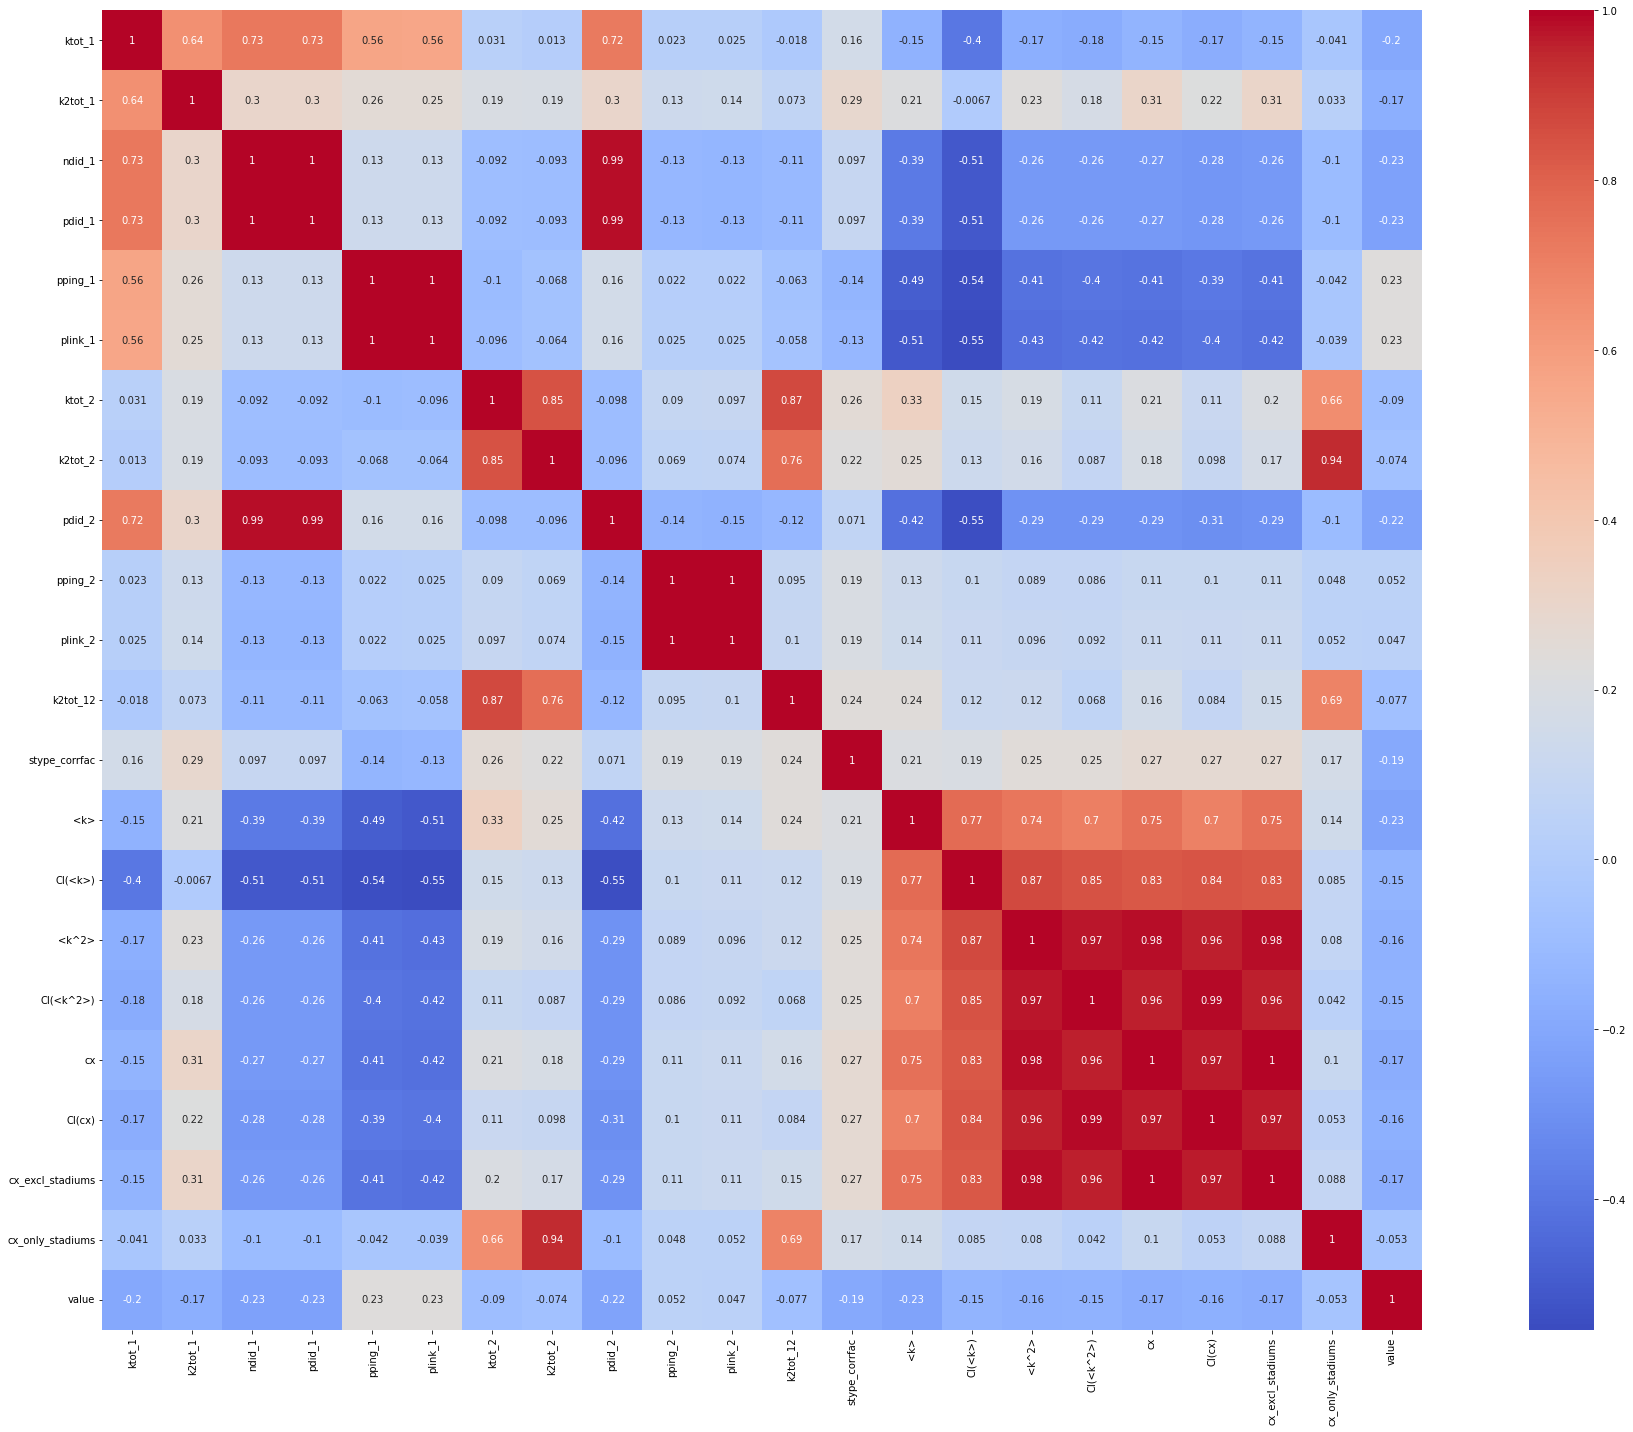

In [13]:
mask = np.zeros_like(combined_df.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(combined_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm', square=True)
combined_df.corrwith(combined_df.value)

(array([18701., 18708., 18718., 18725., 18732., 18739., 18748., 18755.,
        18762.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

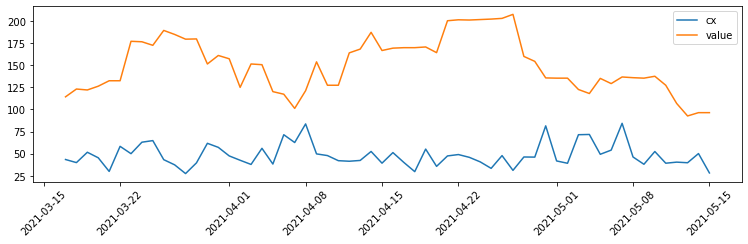

In [14]:
query = """
    select cx from covid_results_v5 crv 
    where crv.location like 'Berlin' 
    and crv.day between '2020-02-01' and '2021-03-16'; 
"""
cur.execute(query)
df2 = pd.DataFrame(cur.fetchall(), columns = ['day', 
                                             'location',
                                             'submitted_on',
                                             'ktot_1',
                                             'k2tot_1',
                                             'ndid_1',
                                             'npop_1',
                                             'pdid_1',
                                             'pping_1',
                                             'plink_1',
                                             'ktot_2',
                                             'k2tot_2',
                                             'ndid_2',
                                             'npop_2',
                                             'pdid_2',
                                             'pping_2',
                                             'plink_2',
                                             'k2tot_12',
                                             'stype_corrfac',
                                             '<k>',
                                             'CI(<k>)',
                                             '<k^2>',
                                             'CI(<k^2>)',
                                             'cx',
                                             'CI(cx)',
                                             'cx_excl_stadiums',
                                             'cx_only_stadiums'
])

print(len(df2.columns), len(df2))
df2.tail(5)
combined_df_test.cx.plot(legend=True)
combined_df_test.value.plot(legend=True)
plt.xticks(rotation=45)

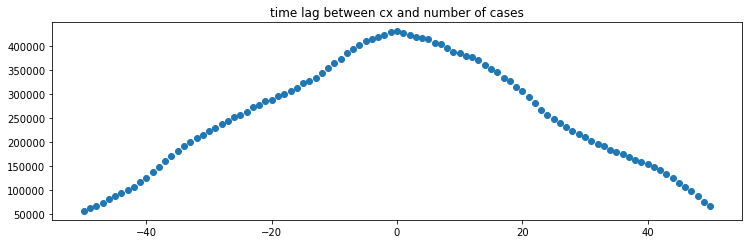

In [101]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss

plt.xcorr(combined_df_test.cx, combined_df_test.value, normed=False, usevlines=False, maxlags=50)
plt.title("time lag between cx and number of cases")
plt.show()

In [89]:
combined_df_test.drop(['corr', 'correlation'], axis=1)

,ktot_1,k2tot_1,ndid_1,pdid_1,pping_1,plink_1,ktot_2,k2tot_2,pdid_2,pping_2,...,stype_corrfac,<k>,CI(<k>),<k^2>,CI(<k^2>),cx,CI(cx),cx_excl_stadiums,cx_only_stadiums,value
2021-03-17,1192,1476,13425,0.004078,0.006903,0.026645,0,0,0.005187,0.001230,...,0.953021,16.179354,0.984753,702.74945,137.195270,43.434950,11.123307,43.434950,0.0,114.261001
2021-03-18,1093,1335,13420,0.004077,0.006996,0.026941,0,0,0.005175,0.001481,...,0.953101,14.683521,0.929441,586.41270,102.754486,39.936790,9.525873,39.936790,0.0,123.070844
2021-03-19,1202,1546,13462,0.004089,0.006968,0.026851,0,0,0.005193,0.001282,...,0.953953,16.101212,0.995845,831.27130,171.063960,51.627872,13.817427,51.627872,0.0,122.002985
2021-03-20,918,1124,12821,0.003895,0.006438,0.025160,0,0,0.004993,0.001250,...,1.002172,14.468341,1.004917,656.34296,128.756760,45.364080,12.050028,45.364080,0.0,126.274424
2021-03-21,748,850,12255,0.003723,0.006146,0.024215,0,0,0.004838,0.000873,...,1.012062,13.406625,0.996311,401.82428,84.678420,29.972069,8.543532,29.972069,0.0,132.414618
2021-03-22,1072,1400,13048,0.003964,0.006770,0.026224,0,0,0.004996,0.000913,...,0.947729,15.650918,1.036468,912.54724,278.104340,58.306310,21.630486,58.306310,0.0,132.414618
2021-03-23,867,1057,12648,0.003842,0.005649,0.022583,0,0,0.004785,0.001637,...,0.946875,15.642798,1.116922,782.59680,194.791140,50.029205,16.024618,50.029205,0.0,176.997766
2021-03-24,1024,1352,12923,0.003926,0.006593,0.025657,0,0,0.004924,0.001770,...,0.950366,15.577513,1.062926,981.22830,232.145020,62.990047,19.200676,62.990047,0.0,176.463836
2021-03-25,1090,1472,13177,0.004003,0.006941,0.026767,0,0,0.004959,0.031548,...,0.954423,15.286908,1.021827,990.37350,280.729580,64.785730,22.694542,64.785730,0.0,172.459361
2021-03-26,1065,1313,13195,0.004008,0.006892,0.026609,0,0,0.004954,0.003312,...,0.955642,14.983866,0.965962,648.05000,135.203320,43.249850,11.811439,43.249850,0.0,189.278153


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train, Y_train = combined_df.iloc[:,:20], combined_df.iloc[:,21]
X_test, Y_test = combined_df_test.iloc[:,:20], combined_df_test.iloc[:,21]
X_test.columns, Y_test

(Index(['ktot_1', 'k2tot_1', 'ndid_1', 'pdid_1', 'pping_1', 'plink_1', 'ktot_2',
        'k2tot_2', 'pdid_2', 'pping_2', 'plink_2', 'k2tot_12', 'stype_corrfac',
        '<k>', 'CI(<k>)', '<k^2>', 'CI(<k^2>)', 'cx', 'CI(cx)',
        'cx_excl_stadiums'],
       dtype='object'),
 2021-03-17    114.261001
 2021-03-18    123.070844
 2021-03-19    122.002985
 2021-03-20    126.274424
 2021-03-21    132.414618
 2021-03-22    132.414618
 2021-03-23    176.997766
 2021-03-24    176.463836
 2021-03-25    172.459361
 2021-03-26    189.278153
 2021-03-27    184.739749
 2021-03-28    179.400450
 2021-03-29    179.667415
 2021-03-30    151.369130
 2021-03-31    160.979868
 2021-04-01    157.242359
 2021-04-02    124.939599
 2021-04-03    151.369130
 2021-04-04    150.568235
 2021-04-05    120.134230
 2021-04-06    117.197615
 2021-04-07    101.179718
 2021-04-08    121.202090
 2021-04-09    153.771814
 2021-04-10    127.342284
 2021-04-11    127.342284
 2021-04-12    163.916483
 2021-04-13    168.1

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import optimizers

scaler = StandardScaler()

scaler.fit(combined_df)
scaled_train=scaler.transform(combined_df)
scaled_test=scaler.transform(combined_df_test)

n_input = 70
n_features = 22
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               49200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 49,301
Trainable params: 49,301
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(generator, epochs=20)

Epoch 1/20
340/340 [==============================] - 4s 9ms/step - loss: 0.3230
Epoch 2/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3175
Epoch 3/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3156
Epoch 4/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3150
Epoch 5/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3141
Epoch 6/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3129
Epoch 7/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3128
Epoch 8/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3123
Epoch 9/20
340/340 [==============================] - 3s 9ms/step - loss: 42893756.0000
Epoch 10/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3122
Epoch 11/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3115
Epoch 12/20
340/340 [==============================] - 3s 9ms/step - loss: 0.3110
Epoch 13/20
340/34

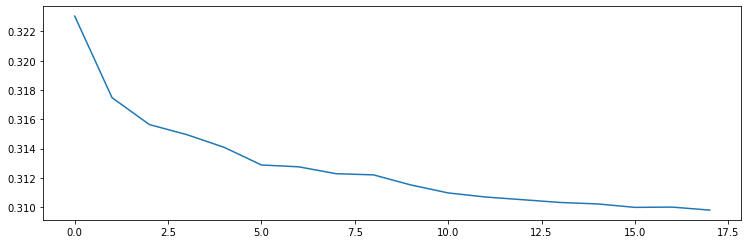

In [21]:
loss_per_epoch = model.history.history['loss']
loss_per_epoch.remove(max(loss_per_epoch))
loss_per_epoch.remove(max(loss_per_epoch))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [22]:
pred = model.predict(scaled_test)
pred_Inverse = scaler.inverse_transform(pred)
pred_Inverse

ValueError: in user code:

    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\nishant.nigam\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 70, 22), found shape=(None, 22)


In [20]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
print(current_batch.shape)

print(type(current_batch), len(current_batch[0]))

for i in range(len(combined_df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)
    print(current_pred, current_pred[0])
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

(1, 60, 22)
<class 'numpy.ndarray'> 60
1/1 [==============================] - 0s 136ms/step
[[-0.3409474]] [-0.3409474]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

# Multivariate Time Series – Vector Auto Regression (VAR)

In [30]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=combined_df)
model_fit = model.fit()

C:\Users\nishant.nigam\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [40]:
prediction = model_fit.forecast(model_fit.endog, steps=len(scaled_test))
prediction[:,-1].shape

(30,)

In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(prediction[:, -1], test['value']))

40.64760605641379